<a href="https://colab.research.google.com/github/hatttruong/fastai-playbook/blob/main/05_from_scratch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear model and neural net from scratch

### Download data

In [1]:
# !pip install kaggle
#

# DO THE FOLLOWING STEPS TO AVOID ERROR "Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method."
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"hatruong","key":"b3f500767704925a7064052e8d4ef2eb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
import os
from pathlib import Path
import zipfile
import kaggle

In [3]:
# download data from Kaggle
path = Path("titanic")
if not path.exists():
    # kaggle.api.competition_leaderboard_cli(str(path))
    !kaggle competitions download -c titanic --force
    zipfile.ZipFile(f'{path}.zip').extractall(path)

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 76.3MB/s]


### Setup

In [4]:
import torch
import numpy as np
import pandas as pd

np.set_printoptions(linewidth=140)
pd.set_option('display.width', 140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)

### Clean Data

In [5]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
modes = df.mode()#.iloc[0]
modes

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3.0,"Abbing, Mr. Anthony",male,24.0,0.0,0.0,1601,8.05,B96 B98,S
1,2,NaN,NaN,"Abbott, Mr. Rossmore Edward",NaN,NaN,NaN,NaN,347082,NaN,C23 C25 C27,NaN
2,3,NaN,NaN,"Abbott, Mrs. Stanton (Rosa Hunt)",NaN,NaN,NaN,NaN,CA. 2343,NaN,G6,NaN
3,4,NaN,NaN,"Abelson, Mr. Samuel",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,"Abelson, Mrs. Samuel (Hannah Wizosky)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,NaN,NaN,"de Mulder, Mr. Theodore",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,888,NaN,NaN,"de Pelsmaeker, Mr. Alfons",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,889,NaN,NaN,"del Carlo, Mr. Sebastiano",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,890,NaN,NaN,"van Billiard, Mr. Austin Blyler",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note: Read more about iloc & loc at https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/

In [8]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [9]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [10]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

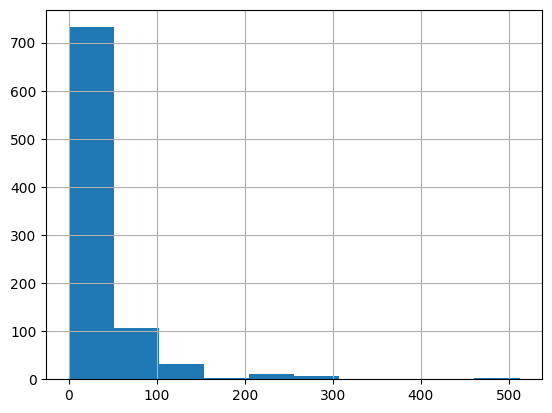

In [11]:
df['Fare'].hist()

<Axes: >

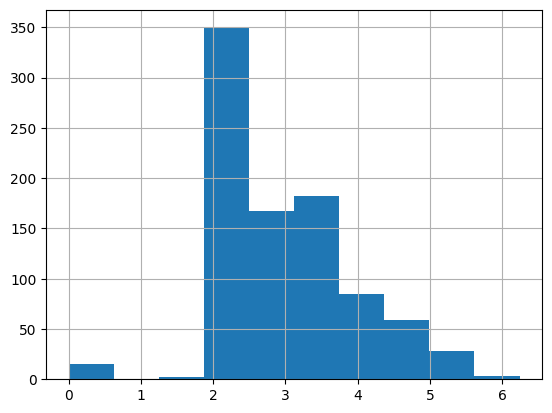

In [12]:
#
df['LogFare'] = np.log(df['Fare'] + 1)
df['LogFare'].hist()

In [13]:
sorted(df['Pclass'].unique())

[1, 2, 3]

In [14]:
df.describe(include=(object))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [15]:
# one-hot vector for categorical columns
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])


In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [17]:
added_columns = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
                 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_columns].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


### Prepare Tensor

In [18]:
from torch import tensor

In [19]:
t_dep = tensor(df.Survived)
t_dep.size()

torch.Size([891])

In [20]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_columns
indep_cols

['Age',
 'SibSp',
 'Parch',
 'LogFare',
 'Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [21]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep.shape

torch.Size([891, 12])

In [22]:
t_indep.shape

torch.Size([891, 12])

In [23]:
len(t_indep.shape) # rank of tensor
# vector is rank 1, matrix is rank 2, scala is rank zero

2

## Setup a linear model

In [24]:
torch.manual_seed(442)

In [25]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5 # move from range [0,1] to [-0.5, 0.5]
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [26]:
t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.3147,   0.0000

Since the sum of every row will be dominated by the first column (age), we need to normalize value of all columns into the same range. Here we choose a simple solution which divide all by the max value of each independence

In [27]:
vals, indices = t_indep.max(dim=0)
vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [28]:
t_indep = t_indep / vals
t_indep

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [29]:
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

create a very simple prediction by adding up the rows of the product

In [30]:
preds = (t_indep * coeffs).sum(axis=1)
preds.shape

torch.Size([891])

In [31]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770])

In [32]:
# calculate the loss using MAE
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5200)

In [33]:
def cal_preds(coeffs, indeps):
    return (indeps * coeffs).sum(axis=1)
def cal_loss(coeffs, indeps, deps):
    return torch.abs(cal_preds(coeffs, indeps) - deps).mean()

## Doing gradient descent

In [34]:
coeffs.requires_grad_()
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [35]:
loss = cal_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [36]:
loss.backward()

In [37]:
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,  0.0797, -0.1886, -0.0617,  0.1639])

In [40]:
# run this code block mutiple times make coeffs.grad bigger and bigger
loss = cal_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.1934,  0.0471, -0.0165, -0.3217, -0.7901,  0.4444, -0.4938, -0.1706,  0.3187, -0.7542, -0.2469,  0.6554])

In [41]:
# to avoid this, reset grad to zero after update
loss = cal_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(cal_loss(coeffs, t_indep, t_dep))

tensor(0.4711)


## Training linear model

In [45]:
from fastai.data.transforms import RandomSplitter

In [48]:
train_split, val_split = RandomSplitter(seed=42)(df)

In [51]:
train_indep, val_indep = t_indep[train_split], t_indep[val_split]
train_dep, val_dep = t_dep[train_split], t_dep[val_split]
len(train_indep), len(val_indep)

(713, 178)

In [52]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [53]:
def epoch(coeffs, lr):
    loss = cal_loss(coeffs, train_indep, train_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f'loss: {loss:.3f}; ')

In [55]:
def init_coeffs():
    return (torch.rand(n_coeff) - 0.5).requires_grad_()

In [58]:
def train_model(epochs=30, lr=0.1):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        # print(f'\nEpoch: {i}')
        epoch(coeffs, lr)
    return coeffs

In [86]:
coeffs = train_model(epochs=18)

loss: 0.503
loss: 0.501
loss: 0.499
loss: 0.497
loss: 0.494
loss: 0.492
loss: 0.490
loss: 0.488
loss: 0.486
loss: 0.484
loss: 0.482
loss: 0.480
loss: 0.478
loss: 0.476
loss: 0.474
loss: 0.472
loss: 0.470
loss: 0.467


In [100]:
def show_coeffs(coeffs):
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs(coeffs)

{'Age': tensor(-1.5097),
 'SibSp': tensor(-1.1564),
 'Parch': tensor(-0.4253),
 'LogFare': tensor(0.2456),
 'Sex_female': tensor(8.4482),
 'Sex_male': tensor(-10.3873),
 'Pclass_1': tensor(3.8377),
 'Pclass_2': tensor(2.1304),
 'Pclass_3': tensor(-6.2481),
 'Embarked_C': tensor(1.4744),
 'Embarked_Q': tensor(2.1067),
 'Embarked_S': tensor(-4.8086)}

## Measuring Accuracy

In [88]:
preds = cal_preds(coeffs, val_indep)

In [89]:
preds

tensor([0.5149, 0.4068, 0.2674, 0.4453, 0.4512, 0.4366, 0.3630, 0.5217, 0.4787, 0.3335, 0.4076, 0.2730, 0.4618, 0.4810, 0.4063, 0.4638,
        0.4325, 0.5297, 0.4228, 0.4827, 0.4199, 0.4465, 0.3789, 0.4983, 0.4271, 0.4004, 0.5418, 0.4372, 0.4299, 0.4811, 0.5573, 0.5303,
        0.4276, 0.4098, 0.5054, 0.5523, 0.4582, 0.3926, 0.4197, 0.4971, 0.4626, 0.4197, 0.4463, 0.3796, 0.4259, 0.5021, 0.3984, 0.4327,
        0.4078, 0.4986, 0.4478, 0.4661, 0.4660, 0.4194, 0.4517, 0.4423, 0.4068, 0.3993, 0.4244, 0.4065, 0.3231, 0.4357, 0.4082, 0.4245,
        0.4938, 0.5010, 0.4528, 0.3869, 0.3898, 0.4945, 0.4168, 0.3421, 0.4438, 0.4183, 0.4972, 0.4324, 0.4197, 0.4667, 0.4607, 0.4157,
        0.4964, 0.4111, 0.4215, 0.4207, 0.4889, 0.3030, 0.3313, 0.5959, 0.3525, 0.4544, 0.4071, 0.4197, 0.3795, 0.2600, 0.3721, 0.2783,
        0.4121, 0.4789, 0.4843, 0.4157, 0.4430, 0.4811, 0.4076, 0.4107, 0.4824, 0.4248, 0.4091, 0.5061, 0.3231, 0.4172, 0.5270, 0.4799,
        0.4958, 0.5363, 0.4197, 0.3427, 0.4766, 

In [90]:
result = val_dep.bool() == (preds > 0.5)
result[:10]

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True, False])

In [91]:
result.float().mean()

tensor(0.6685)

In [92]:
def cal_acc(coeffs):
    return (val_dep.bool() == (cal_preds(coeffs, val_indep) > 0.5)).float().mean()

cal_acc(coeffs)

tensor(0.6685)

## Sigmoid Func

In [93]:
preds[:20]

tensor([0.5149, 0.4068, 0.2674, 0.4453, 0.4512, 0.4366, 0.3630, 0.5217, 0.4787, 0.3335, 0.4076, 0.2730, 0.4618, 0.4810, 0.4063, 0.4638,
        0.4325, 0.5297, 0.4228, 0.4827])

In [94]:
import sympy

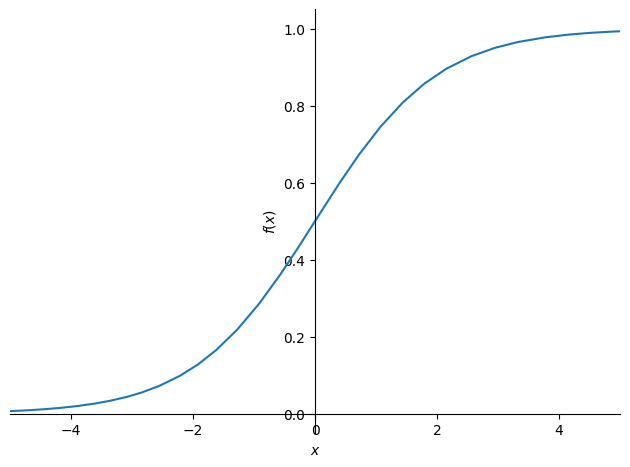

In [80]:
sympy.plot("1/(1 + exp(-x))", xlim=(-5, 5))

In [95]:
def cal_preds(coeffs, indeps):
    return torch.sigmoid((coeffs * indeps).sum(axis=1))

In [96]:
preds = cal_preds(coeffs, val_indep)
preds[:20]

tensor([0.5149, 0.4068, 0.2674, 0.4453, 0.4512, 0.4366, 0.3630, 0.5217, 0.4787, 0.3335, 0.4076, 0.2730, 0.4618, 0.4810, 0.4063, 0.4638,
        0.4325, 0.5297, 0.4228, 0.4827])

In [97]:
coeffs = train_model(lr=100)

loss: 0.503
loss: 0.326
loss: 0.294
loss: 0.207
loss: 0.201
loss: 0.199
loss: 0.198
loss: 0.197
loss: 0.196
loss: 0.196
loss: 0.196
loss: 0.195
loss: 0.195
loss: 0.195
loss: 0.195
loss: 0.195
loss: 0.195
loss: 0.195
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194
loss: 0.194


In [98]:
cal_acc(coeffs)

tensor(0.8258)

In [101]:
show_coeffs(coeffs)

{'Age': tensor(-1.5097),
 'SibSp': tensor(-1.1564),
 'Parch': tensor(-0.4253),
 'LogFare': tensor(0.2456),
 'Sex_female': tensor(8.4482),
 'Sex_male': tensor(-10.3873),
 'Pclass_1': tensor(3.8377),
 'Pclass_2': tensor(2.1304),
 'Pclass_3': tensor(-6.2481),
 'Embarked_C': tensor(1.4744),
 'Embarked_Q': tensor(2.1067),
 'Embarked_S': tensor(-4.8086)}

## A Neural Network

## Deep Learning

# Use Framework
